# Import libraries

In [1]:
#Libraries needed to run the tool
import numpy as np
import pandas as pd
from numpy import mean
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

# Data preprocessing

### Read data from file

In [2]:
#Read the file
file_name = 'Harvesting data'
data = pd.read_excel(file_name + '.xlsx', header=0)


#Print number of rows and colums read
print("{0} rows and {1} columns".format(len(data.index), len(data.columns)))
print("")

152 rows and 7 columns



### Initialization

In [3]:
#Defining X and Y
X = data.drop(columns = ['Water_volume'], axis = 1)
Y = data.Water_volume

#Using Built in train test split function in sklearn
bins = np.linspace(Y.min(), Y.max() + 0.1, 5)
y_binned = np.digitize(Y, bins)

svr_scores = []
svr_score_test = []
svr_mae_test = []
svr_rmse_test = []
svr_best_test = []
svr_best_pred = []

gbm_scores = []
gbm_score_test = []
gbm_mae_test = []
gbm_rmse_test = []
gbm_best_test = []
gbm_best_pred = []

nn_scores = []
nn_score_test = []
nn_mae_test = []
nn_rmse_test = []
nn_best_test = []
nn_best_pred = []

svr_cv_best = 0
svr_r2_best = 0
gbm_cv_best = 0
gbm_r2_best = 0
nn_cv_best = 0
nn_r2_best = 0

# Training and evaluation

In [4]:
for i in tqdm(range(50)):
    data_train, data_test = train_test_split(data, test_size = 0.2,
                                             stratify = y_binned, random_state = i)
    
    #Hacking a scaling but keeping columns names since min_max_scaler does not return a dataframe
    minval = data_train.min()
    minmax = data_train.max() - data_train.min()
    data_train_scaled = (data_train - minval) / minmax
    data_test_scaled = (data_test - minval) / minmax
    
    #Define X and Y
    X_train = data_train_scaled.drop(columns = ['Water_volume'], axis=1)
    Y_train = data_train_scaled.Water_volume
    X_test = data_test_scaled.drop(columns = ['Water_volume'], axis=1)
    Y_test = data_test_scaled.Water_volume
    
    
    #Fit Support Vector Regressor
    svr = SVR(kernel = 'rbf', epsilon = 0.007, gamma = 'scale', C = 0.5)
    
    #Cross Validation (CV) process
    cv_score = cross_val_score(svr, X_train, Y_train, cv = 5)
    svr_scores.append(cv_score.mean())
    
    #Training final algorithms
    svr.fit(X_train, Y_train) #Gradient Boosting fitting
    
    #Saving model
    with open('svr.pkl','wb') as f:
        pickle.dump(svr,f)
    
    #SVR
    svr_test = svr.predict(X_test)
    svr_train = svr.predict(X_train)

    svr_score_test.append(metrics.r2_score(Y_test, svr_test))
    svr_mae_test.append(metrics.mean_absolute_error(Y_test, svr_test))
    svr_rmse_test.append(metrics.root_mean_squared_error(Y_test, svr_test))
    
    if metrics.r2_score(Y_test, svr_test) > svr_r2_best and cv_score.mean() > svr_cv_best :
        svr_r2_best = metrics.r2_score(Y_test, svr_test)
        svr_cv_best = cv_score.mean()
        svr_best_test = Y_test
        svr_best_pred = svr_test
        svr_best_train = Y_train
        svr_best_train_pred = svr_train
        minmax_1 = minmax.iloc[-1]
        minval_1 = minval.iloc[-1]
    
    
    #Fit the Decision tree
    gbm = GradientBoostingRegressor(criterion = 'friedman_mse', n_estimators = 200,
                                    learning_rate = 0.085, max_depth = 2)
    
    
    #Cross Validation (CV) process
    cv_score = cross_val_score(gbm, X_train, Y_train, cv = 5)
    gbm_scores.append(cv_score.mean())
    
    
    #Training final algorithms
    gbm.fit(X_train, Y_train) #Gradient Boosting fitting
    
    #Save model 
    with open('gbm.pkl','wb') as f:
        pickle.dump(gbm,f)
        
    #Gradient Boosting
    gbm_test = gbm.predict(X_test)
    gbm_train = gbm.predict(X_train)

    gbm_score_test.append(metrics.r2_score(Y_test, gbm_test))
    gbm_mae_test.append(metrics.mean_absolute_error(Y_test, gbm_test))
    gbm_rmse_test.append(metrics.root_mean_squared_error(Y_test, gbm_test))
    
    if metrics.r2_score(Y_test, gbm_test) > gbm_r2_best and cv_score.mean() > gbm_cv_best :
        gbm_r2_best = metrics.r2_score(Y_test, gbm_test)
        gbm_cv_best = cv_score.mean()
        gbm_best_test = Y_test
        gbm_best_pred = gbm_test
        gbm_best_train = Y_train
        gbm_best_train_pred = gbm_train
        minmax_2 = minmax.iloc[-1]
        minval_2 = minval.iloc[-1]
        
    
    #Initializing NN
    #acti = ['identity', 'logistic', 'tanh', 'relu']
    #Adding solver as 'lbfgs' since it works better than the default 'adam'
    neural = MLPRegressor(activation = 'logistic', solver = 'lbfgs', max_iter = 2000,
                          hidden_layer_sizes = (6), random_state = 0)
    

    # Cross validataion
    cv_score = cross_val_score(neural, X_train, Y_train, scoring = 'r2', cv = 5)
    nn_scores.append(cv_score.mean())
    
    #Fitting final neural network
    neural.fit(X_train, Y_train)
    
    #Save model
    with open('nn.pkl','wb') as f:
        pickle.dump(neural,f)
    
    nn_test = neural.predict(X_test)
    nn_train = neural.predict(X_train)
    
    nn_score_test.append(metrics.r2_score(Y_test, nn_test))
    nn_mae_test.append(metrics.mean_absolute_error(Y_test, nn_test))
    nn_rmse_test.append(metrics.root_mean_squared_error(Y_test, nn_test))
    
    if metrics.r2_score(Y_test, nn_test) > nn_r2_best and cv_score.mean() > nn_cv_best:
        nn_r2_best = metrics.r2_score(Y_test, nn_test)
        nn_cv_best = cv_score.mean()
        nn_best_test = Y_test
        nn_best_pred = nn_test
        nn_best_train = Y_train
        nn_best_train_pred = nn_train
        minmax_3 = minmax.iloc[-1]
        minval_3 = minval.iloc[-1]

100%|██████████| 50/50 [00:24<00:00,  2.00it/s]


### Reverse scaling

In [5]:
svr_best_test = svr_best_test * minmax_1 + minval_1
svr_best_pred = svr_best_pred * minmax_1 + minval_1
svr_best_train = svr_best_train * minmax_1 + minval_1
svr_best_train_pred = svr_best_train_pred * minmax_1 + minval_1

gbm_best_test = gbm_best_test * minmax_2 + minval_2
gbm_best_pred = gbm_best_pred * minmax_2 + minval_2
gbm_best_train = gbm_best_train * minmax_2 + minval_2
gbm_best_train_pred = gbm_best_train_pred * minmax_2 + minval_2

nn_best_test = nn_best_test * minmax_3 + minval_3
nn_best_pred = nn_best_pred * minmax_3 + minval_3
nn_best_train = nn_best_train * minmax_3 + minval_3
nn_best_train_pred = nn_best_train_pred * minmax_3 + minval_3

# Print results and figures

In [10]:
# print scores

print("Average cross validation score (SVR): {0}".format(mean(svr_scores).round(3)))
svr_scores_arr = np.array(svr_scores) 
print("Standard deviation cross validation score (SVR): {0}".format(np.std(svr_scores_arr).round(3)))
print("Average test set R^2 (SVR): {0}".format(mean(svr_score_test).round(3)))
svr_score_test_arr = np.array(svr_score_test) 
print("Standard deviation R^2 (SVR): {0}".format(np.std(svr_score_test_arr).round(3)))
print("Average test set MAE (SVR): {0}".format(mean(svr_mae_test).round(3)))
print("Average test set RMSE (SVR): {0}".format(mean(svr_rmse_test).round(3)))
print("")


print("Average cross validation score (GBR): {0}".format(mean(gbm_scores).round(3)))
gbm_scores_arr = np.array(gbm_scores) 
print("Standard deviation cross validation score (GBR): {0}".format(np.std(gbm_scores_arr).round(3)))
print("Average test set R^2 (GBR): {0}".format(mean(gbm_score_test).round(3)))
gbm_score_test_arr = np.array(gbm_score_test) 
print("Standard deviation R^2 (GBR): {0}".format(np.std(gbm_score_test_arr).round(3)))
print("Average test set MAE (GBR): {0}".format(mean(gbm_mae_test).round(3)))
print("Average test set RMSE (GBR): {0}".format(mean(gbm_rmse_test).round(3)))
print("")

print("Average cross validation score (MLP): {0}".format(mean(nn_scores).round(3)))
nn_scores_arr = np.array(nn_scores) 
print("Standard deviation cross validation score (MLP): {0}".format(np.std(nn_scores_arr).round(3)))
print("Average test set R^2 (MLP): {0}".format(mean(nn_score_test).round(3)))
nn_score_test_arr = np.array(nn_score_test) 
print("Standard deviation R^2 (MLP): {0}".format(np.std(nn_score_test_arr).round(3)))
print("Average test set MAE (MLP): {0}".format(mean(nn_mae_test).round(3)))
print("Average test set RMSE (MLP): {0}".format(mean(nn_rmse_test).round(3)))
print("")

Average cross validation score (SVR): 0.844
Standard deviation cross validation score (SVR): 0.016
Average test set R^2 (SVR): 0.873
Standard deviation R^2 (SVR): 0.025
Average test set MAE (SVR): 0.067
Average test set RMSE (SVR): 0.084

Average cross validation score (GBR): 0.813
Standard deviation cross validation score (GBR): 0.021
Average test set R^2 (GBR): 0.844
Standard deviation R^2 (GBR): 0.036
Average test set MAE (GBR): 0.074
Average test set RMSE (GBR): 0.093

Average cross validation score (MLP): 0.852
Standard deviation cross validation score (MLP): 0.027
Average test set R^2 (MLP): 0.888
Standard deviation R^2 (MLP): 0.026
Average test set MAE (MLP): 0.063
Average test set RMSE (MLP): 0.079



In [36]:
# Figures

alpha = 0.6
fig = plt.figure(figsize=(27, 7))
ax = fig.add_subplot(1,3,1)

plt.scatter(svr_best_train, svr_best_train_pred, c = 'white', edgecolor = 'red',
            s = 100, label = 'Train')
plt.scatter(svr_best_test, svr_best_pred, c = 'black', edgecolor = 'black', 
            s = 100, label = 'Test')
plt.plot([0,11], [0,11], c = 'black')
plt.xlabel('Actual water harvest [ml]', fontsize = 20)
plt.ylabel('Predicted water harvest [ml]', fontsize = 20)
plt.title('SVR', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 20)
plt.annotate('$R^2$ = ' + str(round(svr_r2_best, 2)), xy=(0.03, 0.92), 
             xycoords='axes fraction', fontsize = 20)
plt.annotate('CV score = ' + str(np.round(svr_cv_best, 2)), xy=(0.03, 0.87), 
             xycoords='axes fraction', fontsize = 20)
ax.text(-0.12, 1, 'a', transform=ax.transAxes, 
            size=25, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=20)



ax = fig.add_subplot(1,3,2)
plt.scatter(gbm_best_train, gbm_best_train_pred, c = 'white', edgecolor = 'red',
            s = 100, label = 'Train')
plt.scatter(gbm_best_test, gbm_best_pred, c = 'black', edgecolor = 'black',
            s = 100, label = 'Test')
plt.plot([0,11], [0,11], c = 'black')
plt.xlabel('Actual water harvest [ml]', fontsize = 20)
#plt.ylabel('Predicted water harvest [ml]', fontsize = 20)
plt.title('GBR', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 20)
plt.annotate('$R^2$ = ' + str(round(gbm_r2_best, 2)), xy=(0.03, 0.92), 
             xycoords='axes fraction', fontsize = 20)
plt.annotate('CV score = ' + str(np.round(gbm_cv_best, 2)), xy=(0.03, 0.87), 
             xycoords='axes fraction', fontsize = 20)
ax.text(-0.12, 1, 'b', transform=ax.transAxes, 
            size=25, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=20)


ax = fig.add_subplot(1,3,3)
plt.scatter(nn_best_train, nn_best_train_pred, c = 'white', edgecolor = 'red',
            s = 100, label = 'Train')
plt.scatter(nn_best_test, nn_best_pred, c = 'black', edgecolor = 'black',
            s = 100, label = 'Test')
plt.plot([0,11], [0,11], c = 'black')
plt.xlabel('Actual water harvest [ml]', fontsize = 20)
#plt.ylabel('Predicted water harvest [ml]', fontsize = 20)
plt.title('MLP', fontsize = 20)
plt.legend(loc = 'lower right', fontsize = 20)
plt.annotate('$R^2$ = ' + str(round(nn_r2_best, 2)), xy=(0.03, 0.92), 
             xycoords='axes fraction', fontsize = 20)
plt.annotate('CV score = ' + str(np.round(nn_cv_best, 2)), xy=(0.03, 0.87), 
             xycoords='axes fraction', fontsize = 20)
ax.text(-0.12, 1, 'c', transform=ax.transAxes, 
            size=25, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=20)


plt.savefig('vs3.svg', dpi = 600, bbox_inches = 'tight')

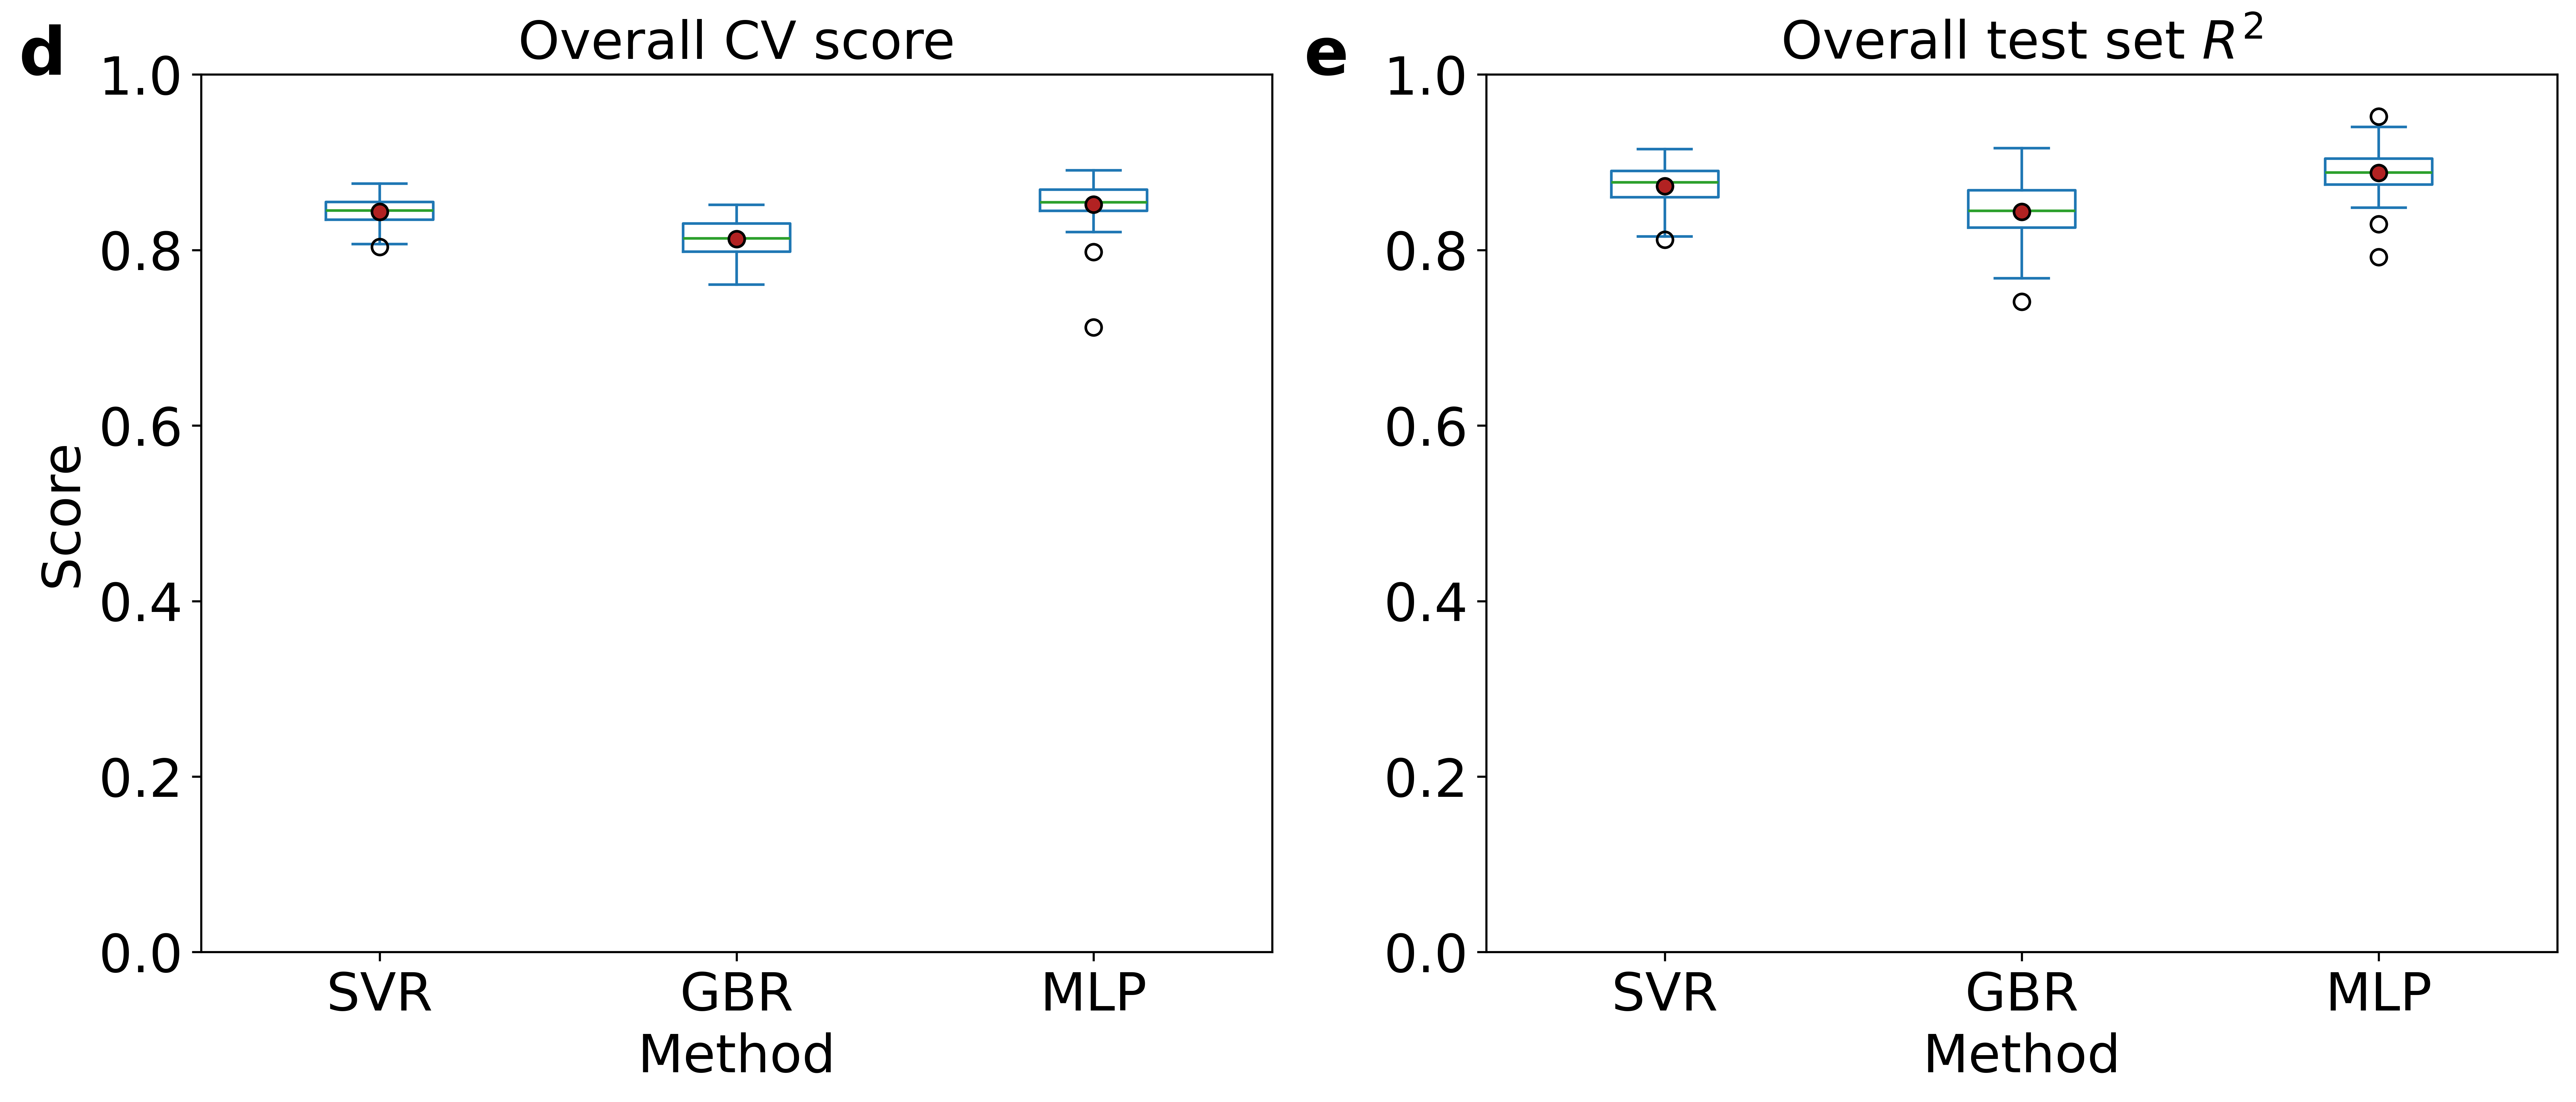

In [31]:
# boxplots

plt.rcParams['figure.dpi'] = 600
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='firebrick')

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 6))
scores = pd.DataFrame({"SVR": svr_scores, "GBR": gbm_scores, "MLP": nn_scores})
ax1 = scores[['SVR', 'GBR', 'MLP']].plot(kind='box', 
                                          showmeans = True, meanprops=meanpointprops,
                                          ax = axes[0])
ax1.set_ylim([0, 1])
ax1.set_ylabel('Score', fontsize = 20)
ax1.set_xlabel('Method', fontsize = 20)
ax1.set_title('Overall CV score', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.text(-0.17, 1, 'd', transform=ax1.transAxes, 
            size=25, weight='bold')

scores = pd.DataFrame({"SVR": svr_score_test, "GBR": gbm_score_test, "MLP": nn_score_test})
ax2 = scores[['SVR', 'GBR', 'MLP']].plot(kind='box', 
                                          showmeans = True, meanprops=meanpointprops,
                                          ax = axes[1])
ax2.set_ylim([0, 1])
#ax2.set_ylabel('Score', fontsize = 20)
ax2.set_xlabel('Method', fontsize = 20)
ax2.set_title('Overall test set $R^2$', fontsize = 20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.text(-0.17, 1, 'e', transform=ax2.transAxes, 
            size=25, weight='bold')


plt.subplots_adjust(hspace=0.3)

plt.savefig('box3.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

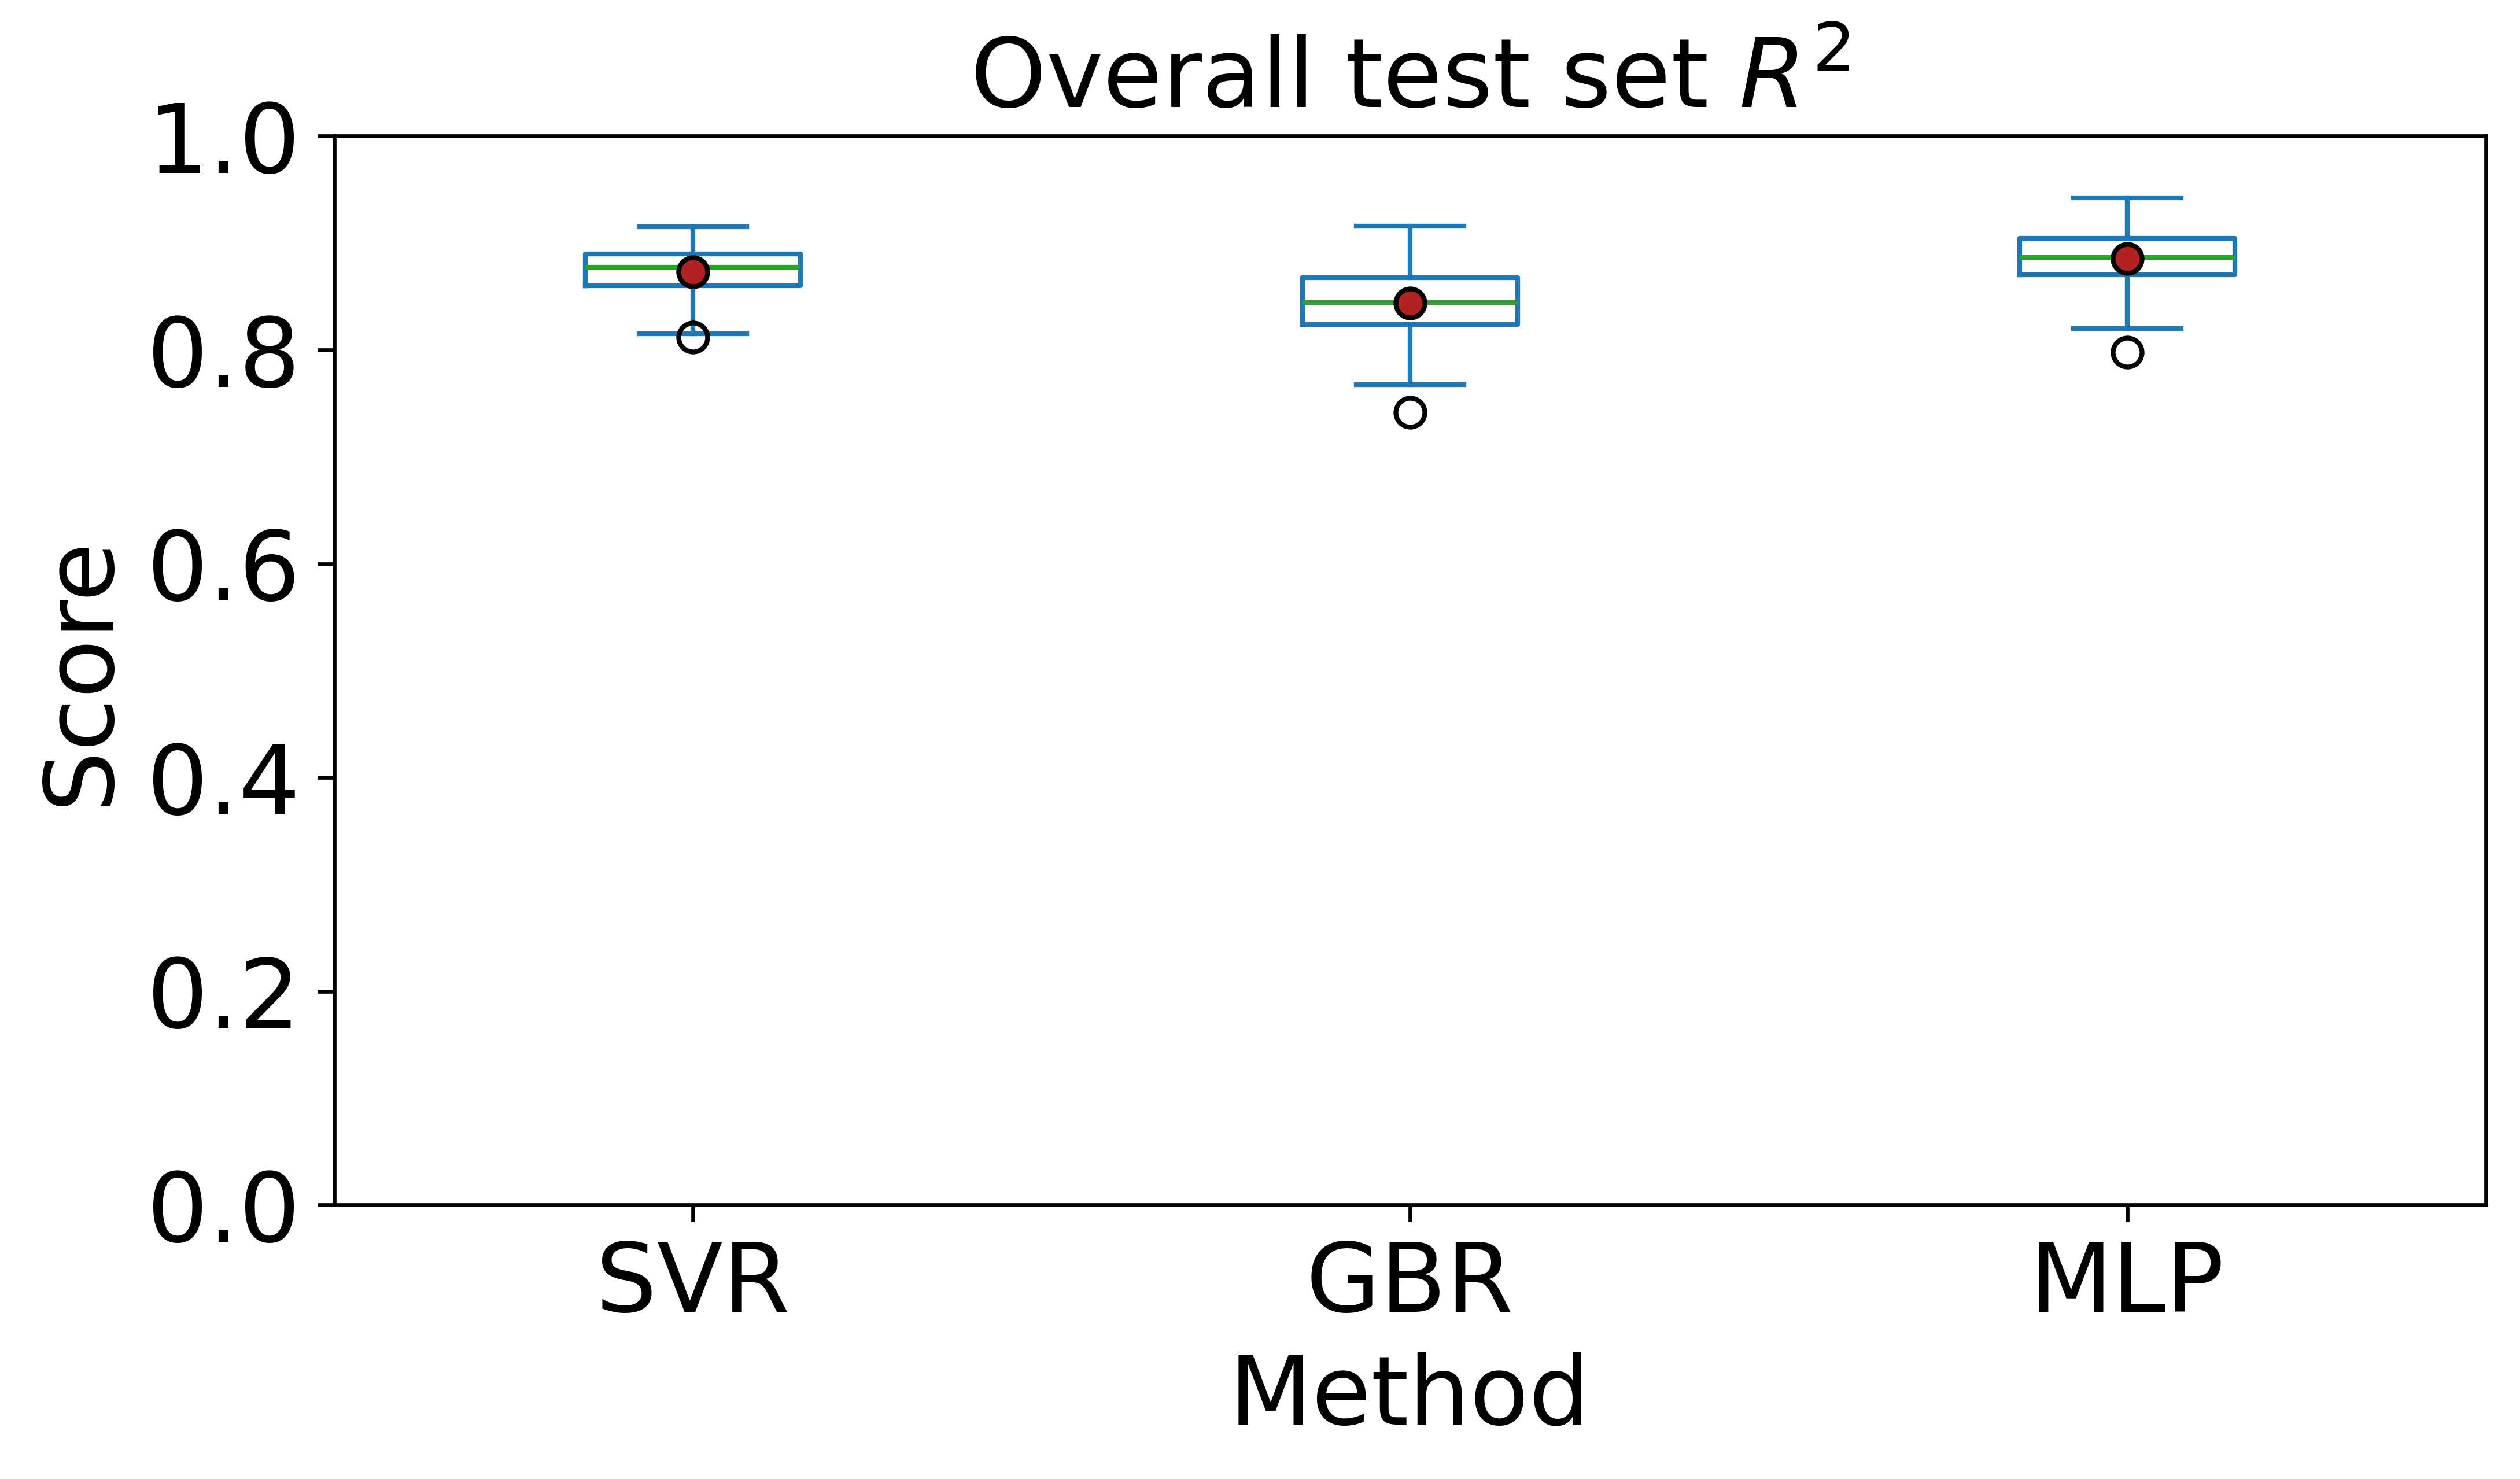

In [11]:
plt.rcParams['figure.dpi'] = 600
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='firebrick')

scores = pd.DataFrame({"SVR": svr_score_test, "GBR": gbm_score_test, "MLP": nn_score_test})
df = scores[['SVR', 'GBR', 'MLP']]

fig = df.plot(kind='box', showmeans = True, meanprops=meanpointprops, figsize = (8, 4))

fig.set_ylim([0, 1])
fig.set_ylabel('Score', fontsize = 20)
fig.set_xlabel('Method', fontsize = 20)
fig.set_title('Overall test set $R^2$', fontsize = 20)
fig.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('box.tiff', dpi = 600, bbox_inches = 'tight')
plt.show()